(start:curve_fit_unc)=
# Including Uncertainty in Curve Fitting

## Lesson overview

In a [previous lesson](start:basicsFitting), we demonstrated the basics of curve fitting using the 
[SciPy library](https://scipy.org/). We first showed how to [fit a line to set of data](link:lineFit) and then 
expanded into [non-linear curve fitting](link:nonlinearFit). We will now continue our discussion into curve fitting by 
showing how to incorporate uncertainty values associated with the $y$-value of a data point into the least squares 
regression analysis. 

## Topics taught

* Performing least squares analysis using the `scipy.optimize.curve_fit()` function.
* Including measurement uncertainty as weights in `scipy.optimize.curve_fit()`.

## Including uncertainty when fitting data

To demonstrate how to do this, let's revisit our 
[non-linear curve fitting example from a previous lesson](link:nonlinearFit). We will reuse the majority of the code 
from this section and update only the necessary lines of code. First, let's download the raw data file 
{download}`MR_data_with_uncertainty.csv <./example_data/MR_data_no_uncertainty.csv>`. This file is slightly different 
from the file we used in the previous example, as it also contains estimates on the uncertainty for both the 
$x$-value (in this case the magnetic field, $B$) and the $y$-value (the resistance, $R$). Even though the data file 
contains the uncertainty on the $x$-values, we will not actually use it in the fitting process, as 
`scipy.optimize.curve_fit()` only accounts for the uncertainty on the $y$-values.

Let's re-run our previous code block with some slight adjustments. See the code below, specifically the 
lines that have the comment `NEW FEATURE HERE!` nearby. We further discuss the changes below.

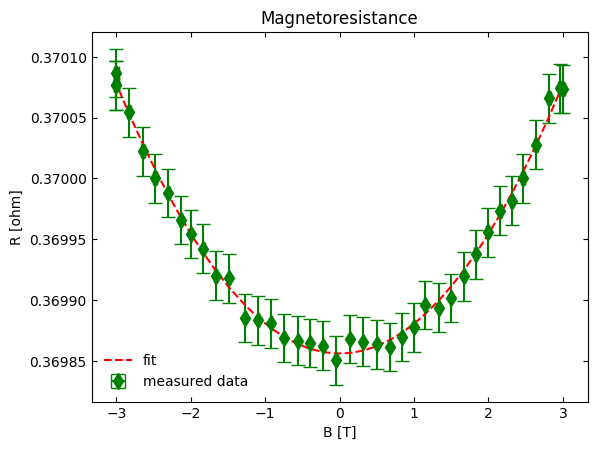

constant = 0.3698562 ohm
constant std. error = 0.0000049 ohm
linear = -2.13E-08 ohm
linear std. error = 1.70E-06 ohm
quadratic = 2.4579E-05 ohm
quadratic std. error = 1.04E-06 ohm


In [1]:
# Load libraries
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

# Create function to fit
def parabolaFunc(x, constant, linear, quadratic):
    y = constant + linear * x + quadratic * (x**2)
    return y

# Load data and separate columns (NEW FEATURE HERE!)
data = np.loadtxt("./example_data/MR_data_with_uncertainty.csv", 
                   delimiter = ",", 
                   skiprows = 2)
magnetic_field = data[:,0]
u_magnetic_field = data[:,1]
resistance = data[:,2]
u_resistance = data[:,3]

# Perform the least-squares fitting (NEW FEATURE HERE!)
popt, pcov = curve_fit(parabolaFunc, magnetic_field, resistance, sigma=u_resistance, absolute_sigma=True)

# Extract out the fitted parameters and standard errors
constant = popt[0]
linear = popt[1]
quadratic = popt[2]
constant_err = np.sqrt(pcov[0][0])
linear_err = np.sqrt(pcov[1][1])
quadratic_err = np.sqrt(pcov[2][2])

# Create figure
fig1 = plt.figure()
ax = fig1.add_subplot(1, 1, 1)

# Plot measured data (NEW FEATURE HERE!)
ax.errorbar(magnetic_field, resistance,
            xerr=u_magnetic_field,
            yerr=u_resistance,
            label="measured data",
            marker="d",
            markersize=8,
            linestyle="none",
            color="green",
            capsize=5)

# Create fitted curve
yfit = constant + (linear * magnetic_field) + (quadratic * (magnetic_field**2))

# Plot fit data
ax.plot(magnetic_field, yfit, 
        color="red",
        label="fit",
        linestyle="dashed")

# Figure options
ax.set_title("Magnetoresistance")
ax.set_xlabel("B [T]")
ax.set_ylabel("R [ohm]")
ax.tick_params(axis="both", direction="in")
ax.tick_params(top="on")
ax.tick_params(right="on")
#ax.set_xlim(left=0, right=2.5)
#ax.set_ylim(bottom=0.3525, top=0.3535)
ax.legend(frameon=False)

# Show plot
plt.show()

# Report values to shell
print(f"constant = {constant:.7f} ohm")
print(f"constant std. error = {constant_err:.7f} ohm")
print(f"linear = {linear:.2E} ohm")
print(f"linear std. error = {linear_err:.2E} ohm")
print(f"quadratic = {quadratic:.4E} ohm")
print(f"quadratic std. error = {quadratic_err:.2E} ohm")

As you can see in the code, this looks very similar to the code used in the 
[non-linear curve fitting example](link:nonlinearFit), but with some minor tweaks:

* After creating the variable `data`, we now create separate 1D arrays for the uncertainty on $B$ and 
  $R$ called `u_magnetic_field` and `u_resistance`, respectively.
* The function `curve_fit()` now contains two additional keyword arguments. The first additional argument is `sigma`, 
  which represents how much we want to "weigh" the importance of a particular data point to the fit. One common 
  weighting method is called "direct weighting" in which we use the uncertainty of the $y$-value as the weighting 
  parameter. In the above example, we do this by setting `sigma=u_resistance` (i.e., the uncertainty in $R$). In this 
  setup, values that have higher uncertainty are weighted more (i.e., prioritized more) in the fit.
* The second keyword argument, `absolute_sigma=True` tells `curve_fit()` to utilize the actual values provided in 
  `sigma` in an absolute sense and not in a relative sense. For new users, it is best to set `absolute_sigma` to `True` 
  for most situations. Further details on this argument can be found in the 
  [online documentation for this function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html).
* When plotting the raw data, we can use the Matplotlib function 
  [`matplotlib.pyplot.errorbar()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html) to 
  include our uncertainty values as "error bars" to the graph. `errorbar()` works very similar to `plot()` and 
  accepts many of the same keyword arguments. The main difference with `errorbar()` is the addition of the keyword 
  arguments `xerr` and `yerr`, which represent the error bar values for the $x$- and $y$-values, respectively. These 
  are optional arguments, so you do not need to include both arguments when plotting (e.g., sometimes you may want 
  to make a plot with just the $y$-value error bars).

And with these changes we now can include the uncertainty of the $y$-values to our fits! As you can see in 
the results, the fitted parameter values and their associated standard errors (i.e., their standard uncertainties) are 
slightly different compared to when we did not include the uncertainty in the fit.

## Conclusion

Adding the uncertainty of values to least squares analysis is straightforward with `scipy.optimize.curve_fit()`. For 
simple analysis routines, it only requires incorporating two optional keyword arguments to the function call. There are 
many ways to expand fitting with uncertainty. One common route is to change the weighting 
of the data in a fit. Our example used a direct weighting scheme, which places more emphasis on data points that 
have higher uncertainty. The default value for `sigma` is `None`, which is equivalent to providing a 1D array of ones. 
This sets the weight for all values equal to one another, and is the default state in `curve.fit()`. This weighting 
scheme was used with the two fitting examples found in the previous [basic curve fitting lesson](start:basicsFitting) 
since `sigma` was not provided in the argument list. There are other ways one can weight the data by modifying what 
goes into `sigma` (e.g., instrumental weighting or statistical weighting). These methods often require one to 
apply a mathematical formula to the uncertainty values in order to weight their importance. 

## Want to learn more?

[Wikipedia - Least Squares](https://en.wikipedia.org/wiki/Least_squares)  
[Shane Burns - Data Fitting with Error](https://faculty1.coloradocollege.edu/~sburns/LinearFitting/SimpleDataFittingWithError.html)  
[SciPy Library - The curve_fit() Function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)  
[NumPy - Documentation Page](https://numpy.org/doc/stable/)  
[Matplotlib - Home Page](https://matplotlib.org/stable/index.html)